# Diffusion-Scheduled Denoising Autoencoder for Anomaly Detection

This notebook demonstrates our anomaly detection method introduced in the KDD 2025 paper.

It includes: training, inference, anomaly scoring, and evaluation on a sample dataset.

📄 [Paper DOI](https://doi.org/10.1145/3711896.3736910)  
📦 [GitHub Repo](https://github.com/sattarov/AnoDDAE)
📄 [Arxiv Link](...)  


# Motivation

The detection of anomalies is a fundamental challenge in data science with critical applications in cybersecurity [43, 63], manufacturing [26, 35], finance [2, 22], and healthcare [14]. Adding noise denotes a key factor in deep learning-based anomaly detection [4, 28]. The type of noise introduced, its magnitude, and spatial distribution, directly affect a model’s ability to discriminate between regular observations and anomalies. 

The effect of noise scheduling on anomaly detection is illustrated in Fig. below. Using a small timestep noise (T = 50), the model preserves the data manifold and improves generalization. In contrast, a large timestep noise (T = 1000) introduces ‘confusion samples’ that distort the model’s alignment with the original data distribution. The observation highlights the impact of integrating scheduled denoising into the autoencoder framework.

Decision boundaries of anomaly scores on a toy dataset learned by DDAE with small (T = 50) and large (T = 1000)
noise magnitudes. Each subfigure shows an explanatory schematic (left) and decision boundary (right). The dashed blue line
represents the original data boundary, while arrows indicate reconstruction direction. With small noise (a), the model preserves the data manifold, enhancing generalization. High noise levels (b) introduce “confusion samples”, causing the distortion of decision boundary, misaligning the model with the true data distribution.

![Model Architecture](noise_view_50.png)
![Model Architecture](noise_view_1000.png)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import math

# Import necessary modules
from data import split_data
from utils import set_seed, evaluate_anomaly_detection

## 1. Load and preprocess dataset
We use a dataset from ADBench (e.g., 17_InternetAds.npz) for illustration.

In [9]:
data = np.load("17_InternetAds.npz", allow_pickle=True)
X, y = data['X'], data['y']
# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
# split the data into training and test sets
x_train, x_test, y_train, y_test = split_data(X, y, train_setting="semi-supervised")
# Set random seed for reproducibility
set_seed(42)

# convert to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


## 2. Initialize the DDAE model
Diffusion-Scheduled Denoising Autoencoder integrates diffusion-based noise scheduling into the denoising autoencoder framework to enhance anomaly detection in tabular data. Traditional DAEs apply fixed-magnitude additive noise, whereas diffusion models apply scheduled noise injection, gradually increasing noise over multiple steps. Unlike conventional DAEs that rely on static noise addition, DDAE adaptively modulates noise levels using a diffusion scheduler, improving anomaly discrimination. 

The Figure below illustrates the comparison of noise addition and denoising mechanisms in Denoising Autoencoder (DAE), Denoising Diffusion Probabilistic Models (DDPM), and Diffusion-Scheduled Denoising Autoencoder (DDAE). DAE applies fixed-magnitude noise, training an autoencoder to reconstruct the original data. DDPM progressively adds and removes noise across multiple steps. DDAE merges both approaches, incorporating DDPM’s scheduled noise addition while  retaining DAE’s reconstruction objective.

![Model Architecture](model_comparison.png)

### 2.1 Diffusion Scheduler ...

In [15]:

class DiffusionScheduler:
    """
    A class to handle the forward diffusion process in a diffusion model.
    This class initializes the noise schedule and provides methods to sample from the forward diffusion process.
    """
    def __init__(self, num_timesteps, device, beta_start=1e-4, beta_end=0.02, scheduler='linear'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.beta_start = beta_start
        self.beta_end = beta_end

        # initialize beta and alpha values
        self.beta = self.init_scheduler(scheduler=scheduler).to(device)
        # self.beta = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def q_sample(self, x_0, t):
        """Forward diffusion process: Sample x_t given x_0."""
        noise = torch.randn_like(x_0)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1)
        return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise, noise
    
    def init_scheduler(self, scheduler):
        """
        Initialize the scheduler.
        
        Parameters:
            scheduler (str): Name of the scheduler.
            
        Returns:
            callable: Scheduler function.
        """
        if scheduler == 'linear':
            return self.linear_noise_schedule(timesteps=self.num_timesteps, beta_start=self.beta_start, beta_end=self.beta_end)
        elif scheduler == 'cosine':
            return self.cosine_noise_schedule(timesteps=self.num_timesteps)
        else:
            raise ValueError(f"Invalid scheduler: {scheduler}")
            
    def linear_noise_schedule(self, timesteps, beta_start=0.0001, beta_end=0.02):
        """
        Generates a linear noise schedule.
        
        Parameters:
            timesteps (int): Total number of timesteps.
            beta_start (float): Initial beta value.
            beta_end (float): Final beta value.
            
        Returns:
            np.ndarray: Array of beta values for each timestep.
        """
        return torch.linspace(beta_start, beta_end, timesteps)
    
    def cosine_noise_schedule(self, timesteps, s=0.008):
        """
        Generates a cosine noise schedule.
        
        Parameters:
            timesteps (int): Total number of timesteps.
            s (float): Small offset to prevent division by zero.
            
        Returns:
            np.ndarray: Array of alpha_bar values for each timestep.
        """
        steps = torch.arange(timesteps + 1)
        f = lambda t: torch.cos((t / timesteps + s) / (1 + s) * torch.pi / 2) ** 2
        alphas_bar = f(steps) / f(torch.zeros(1))
        return alphas_bar[:-1]


### 2.1 Denoiser model

The Denoiser learns to recover clean inputs from their corrupted versions. It comprises an encoder–decoder architecture, where the encoder 𝑓𝜃 maps an input x ∈R𝑑 to a lower-dimensional latent representation z ∈R𝑘, with 𝑘 < 𝑑, and the decoder 𝑔𝜙 reconstructs the input as x = 𝑔𝜙(z).

In [10]:

class DiffusionDenoiser(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024], time_emb_dim=16, activation='lrelu', time_emb_type='sinusoidal'):
        super(DiffusionDenoiser, self).__init__()
        # Timestep embedding: learnable or sinusoidal
        if time_emb_type == 'learnable':
            self.timestep_embedding = nn.Linear(1, time_emb_dim)
        elif time_emb_type == 'sinusoidal':
            self.timestep_embedding = self.sine_cosine_transform_timesteps
        else:
            raise ValueError(f"Invalid time_embedding: {time_emb_type}")

        # Network architecture
        self.time_emb_dim = time_emb_dim
        self.time_emb_type = time_emb_type

        # Main network
        layers = []

        # case when timestep embedding are not used
        if time_emb_dim > 0:
            prev_dim = input_dim + time_emb_dim
        else:
            prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'lrelu':
                layers.append(nn.LeakyReLU())            
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, input_dim))  # Predict noise
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        # Embed t
        if self.time_emb_type == 'learnable':
            t = t.unsqueeze(1)  # Ensure t has shape (batch_size, 1)
        t_embedded = self.timestep_embedding(t)  # Shape: (batch_size, embed_dim)
        
        # Concatenate x and embedded t
        if self.time_emb_dim > 0:
            x = torch.cat([x, t_embedded], dim=1)  # Shape: (batch_size, input_dim + embed_dim)

        # Pass through the network
        return self.network(x)  # Predict noise
    
    # define sinusodial time step embedding
    def sine_cosine_transform_timesteps(self, timesteps, max_period=10000):
        
        # dimension of output
        dim_out = self.time_emb_dim

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)

        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # case: odd output dimension
        if dim_out % 2:
            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding  

### 2.3 DDAE model 
Traditional reconstruction-based models, such as autoencoders, have demonstrated strong performance in anomaly detection by learning to reconstruct normal data while assigning higher reconstruction errors to anomalies. In contrast, diffusion models have shown remarkable success in modeling complex data distributions through progressive noise injection. The diffusion-scheduled denoising autoencoder (DDAE) takes advantage of both approaches by integrating diffusion-based noise scheduling into an autoencoder framework. The DDAE consists of the following three components as illustrated in Fig. 3 and described in the following:

1. **Scheduled Noise Addition**. DDAE replaces static noise addition with a progressive forward diffusion process. At each timestep 𝑡, noise is added incrementally to the input, generating a perturbed sample x𝑡 as defined in Eq. 2. This scheduling produces a smooth degradation from clean data to pure noise in 𝑇 steps, allowing the model to learn reconstruction over varying noise intensities.
2. **Denoising with Timestep Conditioning**. DDAE employs a feedforward encoder–decoder architecture to reconstruct the original input x0 from x𝑡. Timestep information is encoded through sinusoidal position embeddings e𝑡, following Nichol and Dhariwal [39], and concatenated with x𝑡 prior to encoding. The encoder computes a latent representationz = 𝑓𝜃(x𝑡 ⊕e𝑡), which the decoder maps back to a denoised estimate x0 = 𝑔𝜙(z). The model is trained to minimize the mean squared reconstruction loss, as defined by:
3. **Anomaly Scoring**. Samples that deviate from the learned distribution result in higher reconstruction errors, particularly under high noise conditions. DDAE computes anomaly scores as the cumulative mean squared reconstruction error across all diffusion steps 𝑇 , as defined by:

![DDAE Architecture](architecture_overview.png)

In [16]:

class DDAE:
    """
    Easy wrapper for diffusion denoising autoencoder.
    Combines DiffusionDenoiser (network) and DiffusionScheduler (noise injection).
    Provides fit and predict methods.
    """
    def __init__(
            self, 
            # Denoiser parameters
            input_dim,            
            hidden_dim=[64, 64], 
            activation='lrelu', 
            # Diffusion parameters
            num_timesteps=100, 
            beta_start=1e-4,
            beta_end=0.02,
            scheduler='linear',
            # Time embedding parameters
            time_emb_dim=4, 
            time_emb_type='sinusoidal', 
            # training parameters
            epochs=100,
            batch_size=64,
            learning_rate=1e-3,
            device=None,
            eval_epochs=None,
        ):
        self.input_dim = input_dim
        self.T = num_timesteps
        self.device = device if device else torch.device("cpu")
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.eval_epochs = eval_epochs if eval_epochs is not None else epochs

        # Denoiser network
        self.denoiser = DiffusionDenoiser(
            input_dim=input_dim, 
            hidden_dims=hidden_dim, 
            time_emb_dim=time_emb_dim,
            time_emb_type=time_emb_type,
            activation=activation
        ).to(self.device)

        # Diffusion scheduler
        self.scheduler = DiffusionScheduler(
            num_timesteps=num_timesteps, 
            device=self.device,
            beta_start=beta_start,
            beta_end=beta_end,
            scheduler=scheduler
        )

    def fit(self, x_train, x_test, y_train=None, y_test=None):
        """
        Fit the diffusion denoising autoencoder to the training data.
        Args:
            x_train (torch.Tensor): Training data tensor of shape (num_samples, input_dim).
            y_train (torch.Tensor, optional): Labels for training data (not used in unsupervised setting).
        """
        optimizer = Adam(self.denoiser.parameters(), lr=self.learning_rate)
        dataloader = DataLoader(x_train, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            # exp_run_statistics = {'epoch': epoch + 1, 'loss': 0.0}
            self.denoiser.train()
            total_loss = 0
            for x_0 in dataloader:
                x_0 = x_0.to(self.device)
                batch_size = x_0.size(0)
                t = torch.randint(1, self.T, (batch_size,), device=self.device).long()
                # Forward process: Sample x_t and noise
                x_t, noise = self.scheduler.q_sample(x_0, t)
                # Predict noise
                x_0_hat = self.denoiser(x_t, t.float())
                # Loss: MSE between true noise and predicted noise
                loss = nn.MSELoss()(x_0_hat, x_0)
                total_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Log statistics for the epoch
            loss = total_loss / len(dataloader)

            # evaluate model
            if (epoch + 1) % self.eval_epochs == 0:
                anomaly_scores = self.predict(x_test, y_test)
                metrics = evaluate_anomaly_detection(anomaly_scores, y_test)
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f} | PR-AUC: {metrics['PR-AUC']:.4f}, ROC-AUC: {metrics['ROC-AUC']:.4f}")

    # Predict anomaly scores for the input data
    def predict(self, x_test, y_test=None):
        """
        Predict anomaly scores for the input data using the trained denoiser.
        Args:
            x_test (torch.Tensor): Test data tensor of shape (num_samples, input_dim).
            y_test (torch.Tensor, optional): Labels for test data (not used in unsupervised setting).

        Returns:
            torch.Tensor: Anomaly scores for the input data.
        """
        self.denoiser.eval()
        batch_size = 8192 # 8192 is a good batch size for most GPUs
        num_samples = x_test.size(0)
        anomaly_scores = torch.zeros(num_samples)

        with torch.no_grad():
            for t in range(1, self.T):
                for i in range(0, num_samples, batch_size):
                    x_batch = x_test[i:i + batch_size].to(self.device)
                    t_tensor = torch.tensor(t, dtype=torch.int64).repeat(x_batch.size(0)).to(self.device)
                    x_t, _ = self.scheduler.q_sample(x_batch, t_tensor)
                    x_0_hat = self.denoiser(x_t, t_tensor)
                    scores = torch.norm(x_batch - x_0_hat, dim=1).cpu().numpy()
                    anomaly_scores[i:i + batch_size] += scores
        return anomaly_scores



### Initialize the model

In [17]:
# Initialize and train model
model = DDAE(
    input_dim=x_train.shape[1],
    hidden_dim=[512, 512],
    activation="lrelu",
    num_timesteps=100,
    beta_start=0.0001,
    beta_end= 0.02,
    scheduler='linear',
    time_emb_dim=4,
    time_emb_type='sinusoidal',
    epochs=100,
    batch_size=256,
    learning_rate=1e-3,
    eval_epochs=10,
)

## 3. Train the model
We train the model on the dataset and monitor the training loss.

In [18]:
model.fit(x_train, x_test, y_train, y_test)

/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 10/100, Loss: 0.4180 | PR-AUC: 0.6146, ROC-AUC: 0.7355


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 20/100, Loss: 0.2714 | PR-AUC: 0.6926, ROC-AUC: 0.7961


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 30/100, Loss: 0.2215 | PR-AUC: 0.7266, ROC-AUC: 0.8240


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 40/100, Loss: 0.1863 | PR-AUC: 0.7450, ROC-AUC: 0.8402


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 50/100, Loss: 0.1737 | PR-AUC: 0.7542, ROC-AUC: 0.8481


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 60/100, Loss: 0.1611 | PR-AUC: 0.7615, ROC-AUC: 0.8558


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 70/100, Loss: 0.1453 | PR-AUC: 0.7654, ROC-AUC: 0.8593


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 80/100, Loss: 0.1312 | PR-AUC: 0.7714, ROC-AUC: 0.8644


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 90/100, Loss: 0.1327 | PR-AUC: 0.7732, ROC-AUC: 0.8648


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


Epoch 100/100, Loss: 0.1214 | PR-AUC: 0.7752, ROC-AUC: 0.8668


## 4. Predict anomaly scores
We use the trained model to assign anomaly scores to each instance.

In [19]:
scores = model.predict(x_test)

/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_1872/3999791440.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  anomaly_scores[i:i + batch_size] += scores


## 5. Evaluation
We evaluate the model using standard metrics such as ROC AUC.

ROC AUC: 0.8667, PR AUC: 0.7752


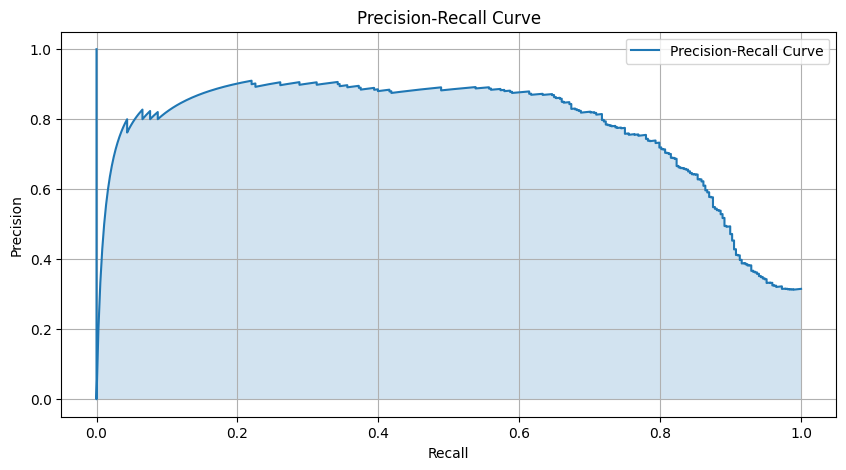

In [20]:
y_test = y_test.numpy()
# compute evaluation metrics
roc_auc = roc_auc_score(y_test, scores)
precision, recall, _ = precision_recall_curve(y_test, scores)
pr_auc = auc(recall, precision)
print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.fill_between(recall, precision, alpha=0.2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

## 6. Visualize anomaly score distribution


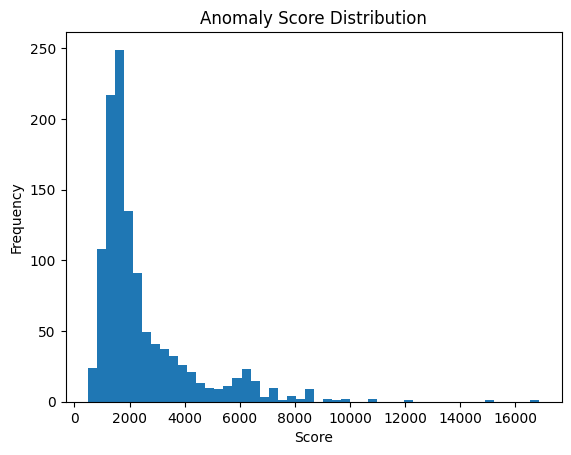

In [21]:
plt.hist(scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

## ✅ Summary
This notebook has demonstrated how to use the diffusion-based autoencoder for anomaly detection.

Feel free to adapt it for your own datasets or extend it for other tasks. Contributions are welcome!
